In [1]:
!pip install -U pyspellchecker
!pip install emoji
!pip install pyLDAvis
!pip install gensim

     |████████████████████████████████| 2.7 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 197 kB 4.4 MB/s eta 0:00:01
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193021 sha256=f5238b046deb71105b47f280d81e34e1d8c1423e6eb1a1dd71e0354ab1c98cb5
  Stored in directory: /Users/e0449486/Library/Caches/pip/wheels/0e/d1/c5/63b511b700c9da5a62bbfc758dd4a3fd9541df51b5db0694b0
Successfully built emoji
     |████████████████████████████████| 1.7 MB 2.4 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 24.0 MB 47.0 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 32.4 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=5e64ebfc650cefa80b8c4878cac962ca7281ce494eddca91d15bd8fbbdd16125
  Stored in directory: /Users/e

# LDA y Modelado por Temas

El modelado por temas es uno de los casos de usos más comunes en NLP ya que nos permite utilizar métodos **no supervisados** para organizar grandes cantidades de información. Por ejemplo, es bastante práctico para ordenar artículos de revistas por tópico, películas por género, canciones por tema, etc. 

Hay varias formas de hacerlo, pero el algoritmo más común es Latent Dirichlet Allocation (LDA), con el cuál trabajaremos en este tutorial. 

En resumen: LDA es una forma de aprendizaje no supervisado que ve los documentos como bolsas de palabras (como vimos anteriormente, se le asigna una representación numérica a una palabra aleatoriamente). 

LDA funciona haciendo primero una suposición aleatoria clave: la forma en que se generó un documento fue escogiendo un conjunto de temas (tópicos) y luego para cada tema escogiendo un conjunto de palabras. En otras palabras, un documento habla de varios temas, y cada tema tiene un set de palabras pertenecientes a ese tema. 

- Para ello, se realiza lo siguiente para cada documento m:
    - Supongamos que hay k temas (tópicos) en todos los documentos. Este valor de k puede ser determinado por el científico de datos como en los ejercicios de clustering tradicionales.
    - Distribuímos estos k tópicos en el documento m (al azar).
    - Para cada palabra w del documento m, se asume que su tema es incorrecto pero que las otras palabras están asignadas al tema correcto. Probabilísticamente, se asigna a la palabra w un tema basado en dos cosas:
        - ¿qué temas están en el documento m?
        - cuántas veces se ha asignado a la palabra w un tema particular en todos los documentos (esta distribución se llama β)

    - Se repite este proceso un número de veces para cada documento hasta que eventualmente, en teoría, las palabras que usualmente están más frecuentemente juntas se encuentren dentro del mismo tópico. 

Al final, el output del modelo es una matriz con todas las palabras, y su probabilidad de pertenecer a cada uno de los temas. 


En este caso, vamos a realizar un LDA con los Tweets de Elon Musk. Veamos de qué le gusta hablar en Redes Sociales.


In [2]:
import re
import tqdm
import pandas as pd
import numpy as np 
from nltk.tokenize import word_tokenize, TweetTokenizer # tokenizador
from string import punctuation 
from nltk.corpus import stopwords # elimina palabras de poco valor
from nltk.stem.wordnet import WordNetLemmatizer # stemming lemming
# Instalamos algunas de las APIs y herramientas de NLTK
import nltk
from spellchecker import SpellChecker

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/e0449486/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/e0449486/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/e0449486/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Helpers 
stopwords_ = set(stopwords.words('english') + list(punctuation)+ ["rt"]) # palabras de poco valor
tknzr = TweetTokenizer() # Tokenizador para Tweeter por NLTK
spell = SpellChecker() # Corrección gramatical
# Asignamos algunas funciones de limpieza básica
replacements = [
            '((www\.[^\s]+)|(https?://[^\s]+))', # url_replace 
            '@[^\s]+', # user_replace 
            '#([^\s]+)', # hash_replace
            "[^A-Za-z' ]+"  # eliminamos todo lo que no sea una letra
            ]
# Re nos permite compilar varias transformaciones en un solo iterador, 
# así nos evitamos iterar varias veces por el mismo documento, incrementando eficiencia. 
regex = re.compile('|'.join(r for r in replacements),re.IGNORECASE)

In [7]:
def stem_lemm(tweet_list):
  """
  Lemmatiza un tweeet uitlizando el lematizador de NLTK
  :param tweet_list: Un tweet tokenizado previamente
  :return: Una lista de tokens
  """
  lem = WordNetLemmatizer()
  normalized_tweet = []
  for word in tweet_list:
      normalized_text = lem.lemmatize(word,'v')
      normalized_tweet.append(normalized_text)
  return normalized_tweet

def limpia_tweets(tweet, use_spell_check=False): 
  """ 
  Función práctica para limpiar y pre-procesar tweets. Incluye: 
  - Eliminación de Hashtags, urls y usuarios 
  - Tokenización 
  - lemmatizer 
  - corrector gramatical (inglés)
  :param tweet: String, cadena de texto, idealmente un Tweet
  :return: Una lista con tokens de tweet.  
  """
  # empezamos transformando a minúsculas
  clean_tweet = tweet.lower()
  # Limpiamos Usuario, Urls y Hashtags
  clean_tweet = regex.sub('', clean_tweet)
  # Añadimos limpieza de caracteres repetidos
  clean_tweet = re.sub(r'(.)\1+', r'\1\1', clean_tweet) 
  # Tokenizamos 
  clean_tweet = tknzr.tokenize(clean_tweet)
  # Quitamos las stopwords
  clean_tweet = [word for word in clean_tweet if word not in stopwords_] # nuestras stopwords
  # lemming y stemming 
  clean_tweet = stem_lemm(clean_tweet)

  if use_spell_check:
    # Encuentra las que tienen errores
    misspelled = spell.unknown(clean_tweet)
    # Corregimos el tweet. 
    clean_tweet = [
        spell.correction(word) if word in misspelled else word for word in clean_tweet]
  return clean_tweet

In [8]:
# Ejemplo 
tweet = '@Tesla What an amaziiiiiing night!!!!. 333 See the pics at www.fakepage.com #Party #TESLA'
limpia_tweets(tweet)

['amaziing', 'night', 'see', 'pics']

# Cargamos los datos y limpieza 

In [9]:
# Data load 
url = 'https://raw.githubusercontent.com/patofw/imf_master/master/Notebooks/data/tweets_data_elonmusk.csv'
data = pd.read_csv(url, encoding='latin-1')
data.head()


,row ID,Tweet,Time,Retweet from,User
0,Row0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,Row1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,Row2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Row3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Row4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [10]:
# tomamos los tweets 
tweets = data.Tweet.values 
# limpieza con nuestra funcion (toma unos minutos)
# usamos TQDM para tener estimado de tiempo en ejecutar
tweets_clean = [limpia_tweets(tweet) for tweet in tqdm.tqdm_notebook(tweets)]
# Cabecera 
tweets_clean[:4]


/var/folders/g9/cjl__p5n18j7_y_2lx39ww4m0000gn/T/ipykernel_24267/3536651422.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tweets_clean = [limpia_tweets(tweet) for tweet in tqdm.tqdm_notebook(tweets)]


  0%|          | 0/3218 [00:00<?, ?it/s]

[['assume',
  'max',
  'acceleration',
  "g's",
  'comfortable',
  'direction',
  'feel',
  'like',
  'mild',
  'moder'],
 ['bfr',
  'capable',
  'transport',
  'satellite',
  'orbit',
  'crew',
  'cargo',
  'complete',
  'missions',
  'moon'],
 ['yup'],
 ['part']]

In [11]:
# Hay tweets demasiado cortos que no aportan mucho valor, eliminamos todos
# los que tienen menos de dos palabras 
# Indices de donde los tweets superan el largo de 2 palabras
mask = [i for i in range(len(tweets_clean)) if len(tweets_clean[i]) > 2]
tweets_entrenamiento = tweets[mask] # Tweets que entran al modelo 
tweets_clean = np.array(tweets_clean)[mask] # filtramos por la máscara
len(tweets_clean)

/var/folders/g9/cjl__p5n18j7_y_2lx39ww4m0000gn/T/ipykernel_24267/3752627259.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tweets_clean = np.array(tweets_clean)[mask] # filtramos por la máscara


2671

In [12]:
tweets_clean[113]

['wigs', 'much', 'delete']

In [13]:
tweets_entrenamiento[113]

'Wigs me out too much. Deleting ...'

# Creación del Modelo 

Antes de crear modelo, es una buena idea inicializar un algoritmo de Ngramas. Esto unirá palabras que usualmente están juntas para que sean consideradas como un solo término. Por ejemplo Big Data, se transforma a big_data. 

## NGramas
 


In [14]:
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  

# Phraser une palabras que usualmente están juntas,
# Por ejemplo Big Data -> big_data
sentences = tweets_clean
phrases = Phrases(sentences, min_count=10, progress_per=10000)
bigram = Phraser(phrases)
ngram_sentences = bigram[sentences] 
# Vemos el vocabulario que hemos creado 
# Sanity check 
word_freq = defaultdict(int)
for sent in ngram_sentences:
    for i in sent:
        word_freq[i] += 1
print(f'El corpus tiene {len(word_freq)} palabras') 

El corpus tiene 4980 palabras


In [15]:
# N gramas que ha creado
{w: v for w,v in word_freq.items() if "_" in w}

{'look_forward': 12,
 'upper_stage': 18,
 'first_stage': 16,
 'come_soon': 15,
 'model_x': 46,
 'next_week': 20,
 'make_sure': 12,
 'pm_et': 15,
 'falcon_heavy': 19,
 'space_station': 17,
 'cape_canaveral': 22,
 'look_like': 25,
 'window_open': 11,
 'static_fire': 12,
 'look_good': 17,
 'solar_power': 13,
 'climate_change': 24,
 'solar_roof': 14,
 'elon_musk': 13}

In [16]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['tesla',
 'model',
 'launch',
 'rocket',
 'land',
 'go',
 'car',
 'good',
 'like',
 'falcon']

In [17]:
# Miramos las palabras más comunes 
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['tesla',
 'model',
 'launch',
 'rocket',
 'land',
 'go',
 'car',
 'good',
 'like',
 'falcon']

## Creación del diccionario con id2word

In [18]:
import gensim.corpora as corpora
# Creamos diccionario de términos para el modelo
id2word = corpora.Dictionary(ngram_sentences)
# Creamos Corpus
texts = ngram_sentences
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Vista computadora 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [19]:
# Vista humano para un tweet
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('acceleration', 1),
  ('assume', 1),
  ('comfortable', 1),
  ('direction', 1),
  ('feel', 1),
  ("g's", 1),
  ('like', 1),
  ('max', 1),
  ('mild', 1),
  ('moder', 1)]]

# Construímos el Modelo LDA 

Ya tenemos todo lo que necesitamos, por lo que vamos a construir el modelo. Haremos algunas configuraciones básicas, pero la más importante es la cantidad de tópicos que queramos tener. Este número depende muchas veces de objetivos de negocio, pero también hay formas de elegir un número óptimo de tópicos. Por ahora utilizaremos prueba y error con el objetivo de ser ilustrativos. 

In [20]:
import gensim
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, # Corpus que creamos
    id2word=id2word, # Vocab
    num_topics=6, # Número de tópicos
    random_state=100, # Semilla 
    update_every=1,# Dejamos por defecto
    chunksize=100, # Mayor número, más rápido el procesamiento
    passes=15, # Iteraciones 
    alpha='auto', # Por Defecto
    per_word_topics=True
) 

In [21]:
import pprint
# Vemos los resultados 
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus] # Asignamos tópicos a cada tweet 

[(0,
  '0.020*"w" + 0.018*"need" + 0.015*"people" + 0.014*"much" + 0.013*"great" + '
  '0.011*"really" + 0.011*"high" + 0.010*"use" + 0.010*"miles" + 0.009*"help"'),
 (1,
  '0.021*"flight" + 0.016*"v" + 0.016*"yes" + 0.013*"actually" + 0.012*"love" '
  '+ 0.012*"tax" + 0.011*"day" + 0.009*"coast" + 0.009*"show" + 0.009*"fire"'),
 (2,
  '0.037*"rocket" + 0.020*"make" + 0.020*"thank" + 0.015*"spacex" + '
  '0.013*"think" + 0.011*"long" + 0.011*"video" + 0.010*"right" + 0.009*"cool" '
  '+ 0.009*"back"'),
 (3,
  '0.040*"launch" + 0.030*"good" + 0.026*"like" + 0.026*"land" + '
  '0.020*"falcon" + 0.016*"article" + 0.015*"one" + 0.015*"cars" + '
  '0.010*"orbit" + 0.010*"super"'),
 (4,
  '0.021*"would" + 0.020*"time" + 0.019*"new" + 0.018*"get" + 0.017*"take" + '
  '0.017*"mar" + 0.016*"first" + 0.013*"best" + 0.011*"us" + 0.011*"i\'m"'),
 (5,
  '0.070*"tesla" + 0.041*"model" + 0.024*"go" + 0.021*"test" + 0.017*"drive" + '
  '0.016*"dragon" + 0.015*"say" + 0.012*"work" + 0.011*"next" + 0.01

# Metricas de evaluación y Visualización

[**Complejidad y Coherencia**](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Topic%20Coherence%20measures%20score%20a,are%20artifacts%20of%20statistical%20inference.)

En resumen, mientras más alto el número de coherence, mejor el modelo.

In [24]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=ngram_sentences, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.566396220809793

Coherence Score:  0.45996498354487914


In [25]:
import pyLDAvis
import pyLDAvis.gensim_models  # importante 
# Visualizamos
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/e0449486/opt/anaconda3/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.310494  0.064611       1        1  19.892562
0     -0.062143 -0.127666       2        1  17.266831
4      0.014847 -0.116384       3        1  17.217253
2     -0.122166  0.279701       4        1  16.857885
3     -0.091455 -0.070025       5        1  15.847930
1     -0.049576 -0.030236       6        1  12.917538, topic_info=         Term        Freq       Total Category  logprob  loglift
161     tesla  323.000000  323.000000  Default  30.0000  30.0000
398     model  189.000000  189.000000  Default  29.0000  29.0000
224    launch  149.000000  149.000000  Default  28.0000  28.0000
61     rocket  145.000000  145.000000  Default  27.0000  27.0000
103      good  112.000000  112.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2109     free   16.881095   17.567887   Topic6  -5.1796   2.0067
1612    break   16.628169   17.307355   Topic6  -5.1947   2.0066
257       low   16.360848   17.036374   Topic6  -5.2109   2.0061
2200   carbon   16.355596   17.033193   Topic6  -5.2113   2.0060
4874  nytimes   16.835217   17.744159   Topic6  -5.1824   1.9940

[215 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
388       6  0.973558  actually
1207      6  0.946092       aim
841       4  0.967872       air
227       2  0.991541     allow
873       5  0.959641    almost
...     ...       ...       ...
112       3  0.992090     would
541       2  0.977257      yeah
446       1  0.993645      year
63        5  0.991566     years
406       6  0.996273       yes

[187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 5, 3, 4, 2])

# Clustering con los resultados del LDA 

El modelo de LDA nos permite que cada frase tenga su pertenencia a cada tópico. Esta pertenencia es una probabilidad (0-1) por lo que por ejemplo. Si nos imaginamos una tabla plana tendrás como filas un id del tweet y como columnas su pertencia probabilística a cada tópica. Esto es en pocas palabras, una matriz. Esa matriz nos permite hacer clusters!

In [26]:
[(id2word[id], freq) for id, freq in corpus[1]]

[('bfr', 1),
 ('capable', 1),
 ('cargo', 1),
 ('complete', 1),
 ('crew', 1),
 ('missions', 1),
 ('moon', 1),
 ('orbit', 1),
 ('satellite', 1),
 ('transport', 1)]

In [27]:
# La pertenencia está en el primer elemento de doc_lda de cada frase
doc_lda[1][0]

[(0, 0.13522552),
 (1, 0.05920472),
 (2, 0.078856744),
 (3, 0.35659304),
 (4, 0.16588302),
 (5, 0.20423695)]

In [28]:
def get_lda_topics_to_dataframe(list_of_texts, id2word,lda_model ):
    """
    Convenient method to handle the membership value of a list of texts for each topic in an LDA MODEL
    developed by GENSIM LDA. 
    
    Returns: 
    lda_topic_matrix: An array with each text and within, the membership value to each topic in the LDA model. Basically, 
    a list of lists
    df_ : A dataframe with the amount of columns as topics, and rows as number of texts. The value in each cell represents 
    the membership value. 
    
    :param list_of_texts: A list of sentences preprocessed to be input into the LDA MODEL. The function bigram_preparation_text outputs 
    a text with the proper format. But in any case, its just a sentence with each word as an item of a list. Ex : Hello, How are you? -->
    [hello, how, are, you] 
    :param id2word : Dictionary created to train the LDA MODEL as described by the Gensim Dictionary function 
    :param lda_model : The LDA MODEL as trained by Gensim.  

    """
    id2word_matrix = [id2word.doc2bow(sentence) for sentence in list_of_texts]
    lda_topic_matrix = lda_model[id2word_matrix]
    lda_topic_matrix = [topic[0] for topic in lda_topic_matrix]
    
    super_list = []
    for i in range(len(lda_topic_matrix)): 
        l = lda_topic_matrix[i]
        list_ = []
        for ii in range(len(l)): 
            v = l[ii][1]
            list_.append(v)
        super_list.append(list_)
        
        
    cols = []
    for i in range(len(l)): 
        col = "lda_topic_"+str(i)
        cols.append(col)    
    df_ = pd.DataFrame(super_list, columns=cols)

    return lda_topic_matrix, df_

In [29]:
_,df = get_lda_topics_to_dataframe(ngram_sentences, id2word,lda_model )

In [30]:
df.head()

,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4,lda_topic_5
0,0.083004,0.062510,0.082906,0.592933,0.082352,0.096295
1,0.135225,0.059205,0.078857,0.356591,0.165886,0.204236
2,0.148821,0.374290,0.087073,0.140939,0.147502,0.101373
3,0.117046,0.089556,0.116309,0.107702,0.220419,0.348968
4,0.172442,0.147425,0.100596,0.091932,0.370466,0.117140


/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


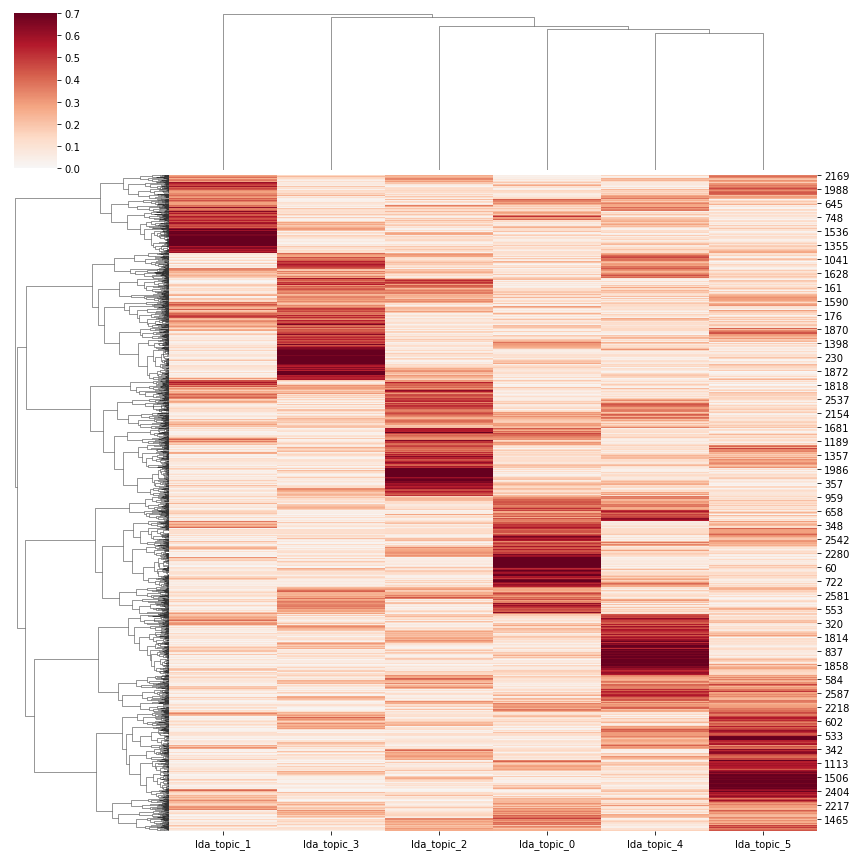

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(df, center=0, standard_scale=1, 
                   cmap="RdBu_r", metric='cosine',
                   vmax = 0.7, vmin = 0,
                   figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [32]:
n = 1311
[(id2word[id], freq) for id, freq in corpus[n]]

[('new', 1), ('team', 1), ('welcome', 1), ('members', 1), ('fantastic', 1)]

In [33]:
doc_lda[n][0]

[(0, 0.1071321),
 (1, 0.15751472),
 (2, 0.12385684),
 (3, 0.09791161),
 (4, 0.32906947),
 (5, 0.1845153)]

In [34]:
tweets_entrenamiento[n]

'RT @OpenAI: We have some fantastic new team members: https://t.co/vvpHyzz9nE. Welcome!'

In [35]:
n = 657
[(id2word[id], freq) for id, freq in corpus[n]]

[('fuel', 1),
 ('need', 1),
 ('high', 1),
 ('pressure', 1),
 ('use', 1),
 ('side', 1),
 ('fluid', 1),
 ('dedicate', 1),
 ('bleed', 1),
 ('kerosene', 1),
 ('pump', 1),
 ('rp', 1),
 ('turbopump', 1)]

In [36]:
doc_lda[n][0]

[(0, 0.22099644),
 (1, 0.051491804),
 (2, 0.11791097),
 (3, 0.06230564),
 (4, 0.4184616),
 (5, 0.12883353)]

In [37]:
tweets_entrenamiento[n]


'@zperrin99 Uses high pressure bleed off the fuel side (RP-1 kerosene) turbopump, so no dedicated pump or fluid needed'

In [38]:
n = 1712
[(id2word[id], freq) for id, freq in corpus[n]]

[('mar', 1),
 ('liquid', 1),
 ('detail', 1),
 ('strong', 1),
 ('water', 2),
 ('evidence', 1),
 ('flow', 1),
 ('presentday', 1)]

In [39]:
doc_lda[n][0]

[(0, 0.21012288),
 (1, 0.061861712),
 (2, 0.082585655),
 (3, 0.1358954),
 (4, 0.21067832),
 (5, 0.298856)]